# Identify Starcraft 2 alliases
A Machine learning solution for **identifying avatar aliases** in Starcraft 2 based on matrix
confusion analysis of different classifiers trained on player behavioural data.
![Starcraft image](https://austin.dreamhack.com/17/wp-content/uploads/2016/12/SC2DreamHack.jpg)

This implementation is based on the following scientific paper :
* Olivier Cavadenti, Victor Codocedo, Jean-François Boulicaut, Mehdi Kaytoue. Identifying Avatar
Aliases in Starcraft 2. http://arxiv.org/abs/1508.00801. 2015. <hal-01180151v2>
* You can find a useful presentation on the topic [here](https://dtai.cs.kuleuven.be/events/MLSA15/slides/session3_talk2_mehdi.pdf) 

In [1]:
%config IPCompleter.greedy=True #enable auto complete

#### Import dependencies 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree,preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
from imblearn.over_sampling import RandomOverSampler
from pandas.plotting import parallel_coordinates,scatter_matrix
from collections import Counter

#### Load and clean the data

In [3]:
#Load first dataset into a pd DataFrame
data = arff.loadarff('starcraft-a.arff')
df = pd.DataFrame(data[0])
#Handle encoding for the nominal columns
for feature in ['race','status','user']:
    df[feature] = df[feature].str.decode('utf-8')
#get rid of the feature names in front of the data for the race and status columns 
for i in range(df.shape[0]): #iterate over all the rows
    df.iloc[i,0]=df.iloc[i,0].split(':')[1]
    df.iloc[i,1] =df.iloc[i,1] .split(':')[1]

In [4]:
list(df.columns)

['race',
 'status',
 'user',
 's',
 'hotkey40',
 'hotkey30',
 'hotkey32',
 'hotkey42',
 'hotkey20',
 'hotkey10',
 'hotkey12',
 'Base',
 'hotkey50',
 'hotkey52',
 'hotkey22',
 'SingleMineral',
 'hotkey60',
 'hotkey70',
 'hotkey80',
 'hotkey90',
 'hotkey00',
 'hotkey01',
 'hotkey62',
 'hotkey02',
 'hotkey92',
 'hotkey82',
 'hotkey72',
 'hotkey41',
 'hotkey51',
 'hotkey61',
 'hotkey21',
 'hotkey71',
 'hotkey81',
 'hotkey91',
 'hotkey11',
 'hotkey31',
 'APM']

#### Explore and visualize the data

In [5]:
#Get information about the data from arff file
data[1]

Dataset: en_taro_adun
	race's type is nominal, range is ('race:Zerg', 'race:Protoss', 'race:Terran')
	status's type is nominal, range is ('status:Win', 'status:Loss')
	user's type is nominal, range is ('http://us.battle.net/sc2/en/profile/3202227/1/', 'http://eu.battle.net/sc2/en/profile/3973341/1/', 'http://kr.battle.net/sc2/en/profile/2343479/1/', 'http://us.battle.net/sc2/en/profile/4665241/1/', 'http://eu.battle.net/sc2/en/profile/3538115/1/', 'http://kr.battle.net/sc2/en/profile/2342120/1/', 'http://eu.battle.net/sc2/en/profile/377576/1/', 'http://eu.battle.net/sc2/en/profile/3074362/1/', 'http://eu.battle.net/sc2/en/profile/2896854/1/', 'http://kr.battle.net/sc2/en/profile/2348639/1/', 'http://kr.battle.net/sc2/en/profile/2342419/1/', 'http://kr.battle.net/sc2/en/profile/2341467/1/', 'http://kr.battle.net/sc2/en/profile/2343067/1/', 'http://kr.battle.net/sc2/en/profile/2342343/1/')
	s's type is numeric
	hotkey40's type is numeric
	hotkey30's type is numeric
	hotkey32's type is nu

In [6]:
df.head()

,race,status,user,s,hotkey40,hotkey30,hotkey32,hotkey42,hotkey20,hotkey10,...,hotkey41,hotkey51,hotkey61,hotkey21,hotkey71,hotkey81,hotkey91,hotkey11,hotkey31,APM
0,Protoss,Win,http://kr.battle.net/sc2/en/profile/2341467/1/,65.0,17.0,1.0,86.0,51.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.536842
1,Protoss,Win,http://kr.battle.net/sc2/en/profile/2341467/1/,65.0,11.0,1.0,84.0,48.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.118881
2,Protoss,Loss,http://kr.battle.net/sc2/en/profile/2341467/1/,70.0,12.0,3.0,78.0,29.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.286885
3,Protoss,Loss,http://kr.battle.net/sc2/en/profile/2341467/1/,46.0,16.0,1.0,40.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.346380
4,Protoss,Win,http://kr.battle.net/sc2/en/profile/2341467/1/,56.0,5.0,3.0,71.0,32.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.040564


In [7]:
df.tail()

,race,status,user,s,hotkey40,hotkey30,hotkey32,hotkey42,hotkey20,hotkey10,...,hotkey41,hotkey51,hotkey61,hotkey21,hotkey71,hotkey81,hotkey91,hotkey11,hotkey31,APM
339,Terran,Win,http://eu.battle.net/sc2/en/profile/2896854/1/,86.0,0.0,1.0,141.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.959029
340,Protoss,Win,http://eu.battle.net/sc2/en/profile/3074362/1/,54.0,1.0,2.0,53.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.193548
341,Protoss,Win,http://eu.battle.net/sc2/en/profile/3074362/1/,57.0,1.0,2.0,58.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.726257
342,Protoss,Loss,http://eu.battle.net/sc2/en/profile/3074362/1/,53.0,0.0,1.0,56.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.856287
343,Protoss,Win,http://eu.battle.net/sc2/en/profile/3074362/1/,53.0,0.0,1.0,66.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.502742


In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s,344.0,80.188953,44.591398,3.000000,49.000000,68.000000,95.000000,224.000000
hotkey40,344.0,1.700581,4.001516,0.000000,0.000000,0.000000,1.000000,20.000000
hotkey30,344.0,1.270349,1.574077,0.000000,0.000000,1.000000,2.000000,8.000000
hotkey32,344.0,40.404070,48.788257,0.000000,0.000000,13.500000,73.250000,181.000000
hotkey42,344.0,32.549419,54.117278,0.000000,0.000000,0.000000,52.250000,231.000000
hotkey20,344.0,1.991279,2.663310,0.000000,1.000000,1.000000,2.000000,15.000000
hotkey10,344.0,1.366279,2.033143,0.000000,0.000000,1.000000,1.000000,14.000000
hotkey12,344.0,28.252907,49.014337,0.000000,0.000000,6.000000,27.000000,214.000000
Base,344.0,3.267442,5.760374,0.000000,0.000000,2.000000,2.000000,28.000000
hotkey50,344.0,0.424419,0.670135,0.000000,0.000000,0.000000,1.000000,3.000000


In [9]:
#Get the total number of games for each player 
df.groupby('user').user.count().reset_index(name='count').sort_values('count',ascending=False)

,user,count
5,http://kr.battle.net/sc2/en/profile/2341467/1/,37
10,http://kr.battle.net/sc2/en/profile/2343479/1/,30
8,http://kr.battle.net/sc2/en/profile/2342419/1/,29
2,http://eu.battle.net/sc2/en/profile/3538115/1/,28
0,http://eu.battle.net/sc2/en/profile/2896854/1/,26
1,http://eu.battle.net/sc2/en/profile/3074362/1/,24
4,http://eu.battle.net/sc2/en/profile/3973341/1/,23
6,http://kr.battle.net/sc2/en/profile/2342120/1/,23
11,http://kr.battle.net/sc2/en/profile/2348639/1/,22
3,http://eu.battle.net/sc2/en/profile/377576/1/,21


In this particular dataset the minimum number of games for a player is $\theta$ = 20

In [10]:
#Let's look at the variance of the different features
df.var()

s                1988.392764
hotkey40           16.012128
hotkey30            2.477719
hotkey32         2380.293978
hotkey42         2928.679766
hotkey20            7.093218
hotkey10            4.133670
hotkey12         2402.405239
Base               33.181911
hotkey50            0.449081
hotkey52         2074.075666
hotkey22          694.045351
SingleMineral     331.125288
hotkey60            0.199573
hotkey70            0.077421
hotkey80            0.082234
hotkey90            0.136687
hotkey00            0.841269
hotkey01            0.000000
hotkey62         1888.215710
hotkey02          818.270722
hotkey92            0.002907
hotkey82            0.000000
hotkey72            0.000000
hotkey41            0.002907
hotkey51            0.000000
hotkey61            0.000000
hotkey21            0.005797
hotkey71            0.000000
hotkey81            0.000000
hotkey91            0.000000
hotkey11            0.002907
hotkey31            0.000000
APM              1340.342329
dtype: float64

High variance for APM,S,SingleMineral and hotkeys 02,62,22,52,12,32,42 **may** indicate good features for classification.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0EF3AC90>,
      dtype=object)

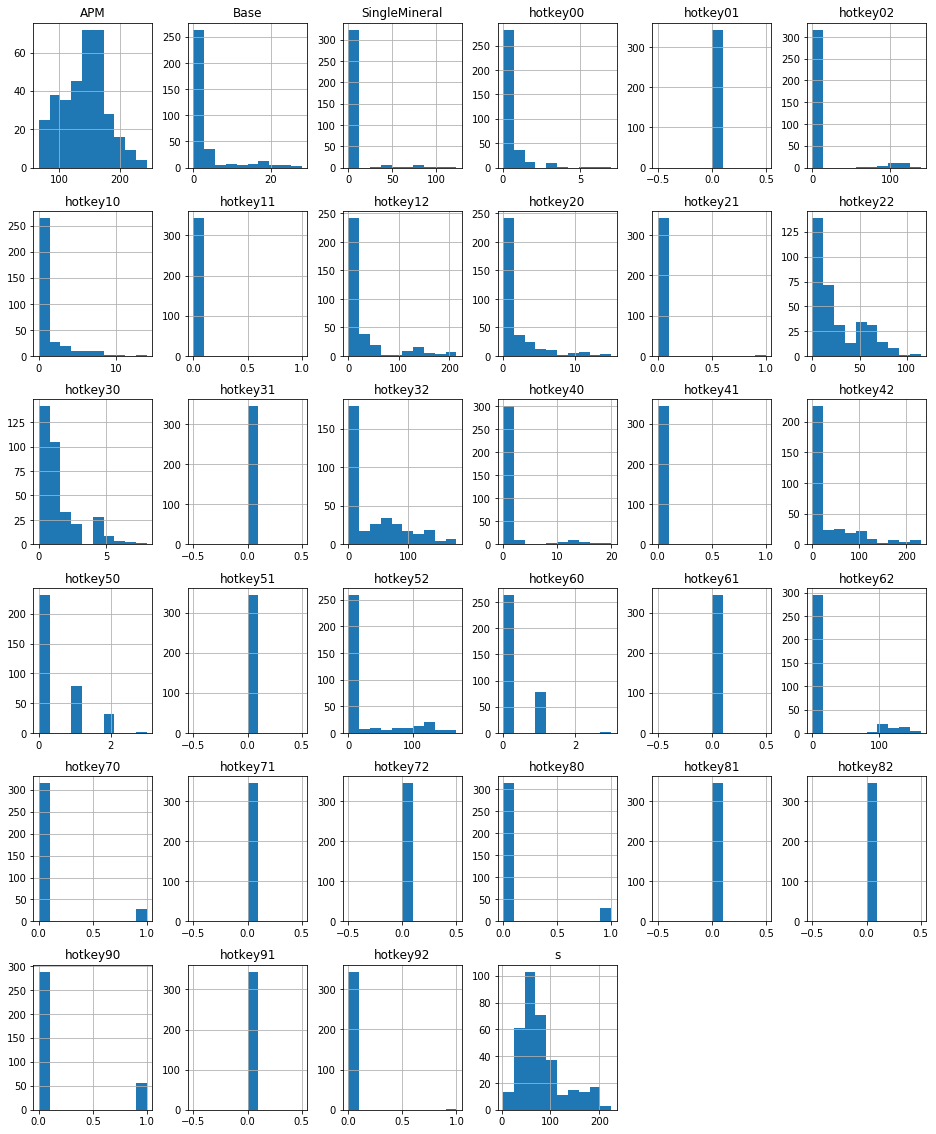

In [11]:
#examine the distribution of the different feature columns
df.hist(figsize = (16,20), stacked= False)

* Distributions of S and APM and Base features look more or less like non-central normal distributions.
* Distribution of different features is going to be usufull for choosing the normalization method we will use later.
* Most hotkeys are either never or rarely used.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104DFB10>,
      dtype=object)

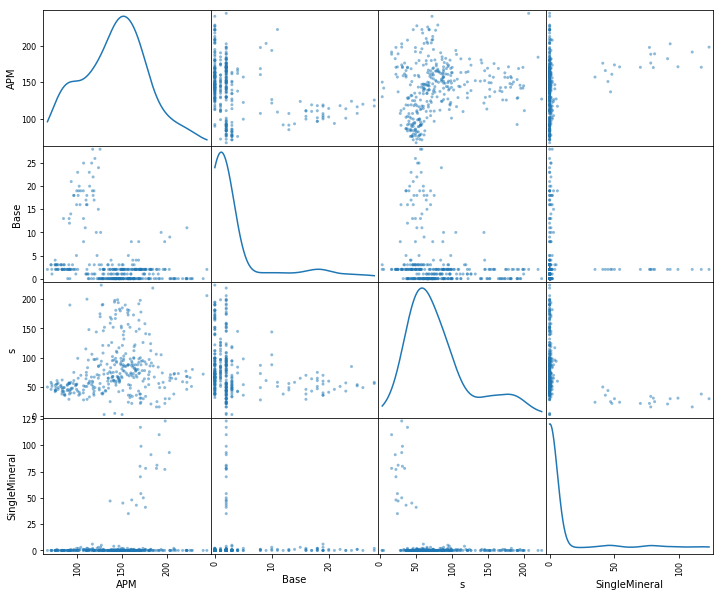

In [12]:
#scatter plots
plt.figure()
#We choose some features to plot
scatter_matrix(df[['APM','Base','s','SingleMineral']], figsize=(12,10),diagonal='kde')

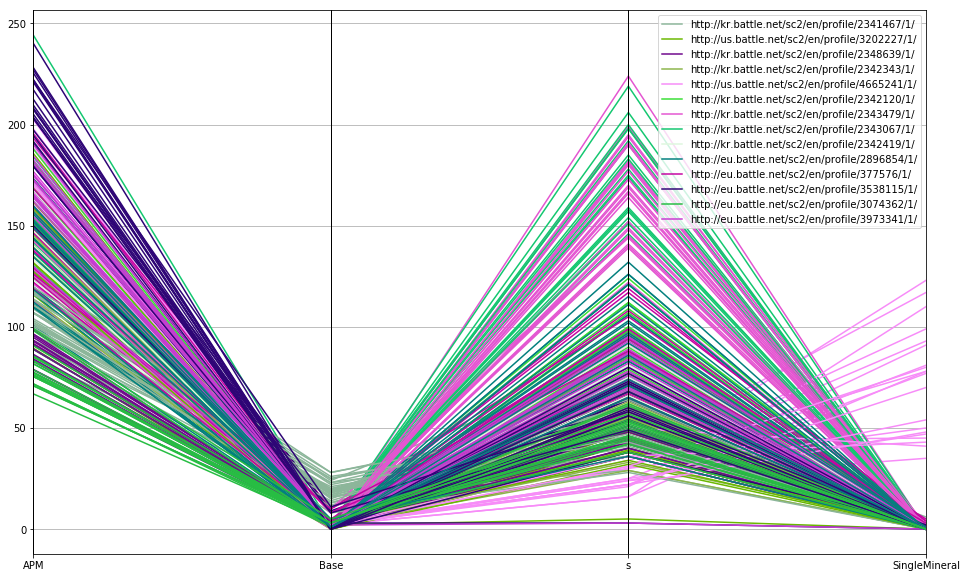

In [13]:
#parallel coordinates
plt.figure(figsize = (16,10))
parallel_coordinates(df[['user','APM','Base','s','SingleMineral']],'user')

* The singleMineral feature separates the "player purple" from the others.
* Apm and S are also probably going to be "good features".
* "Player yellow" has a high base, this tells us that he selects very special buildings a lot.

Let's look at some other high variance features and see if we can spot some other **behavioural traits**.

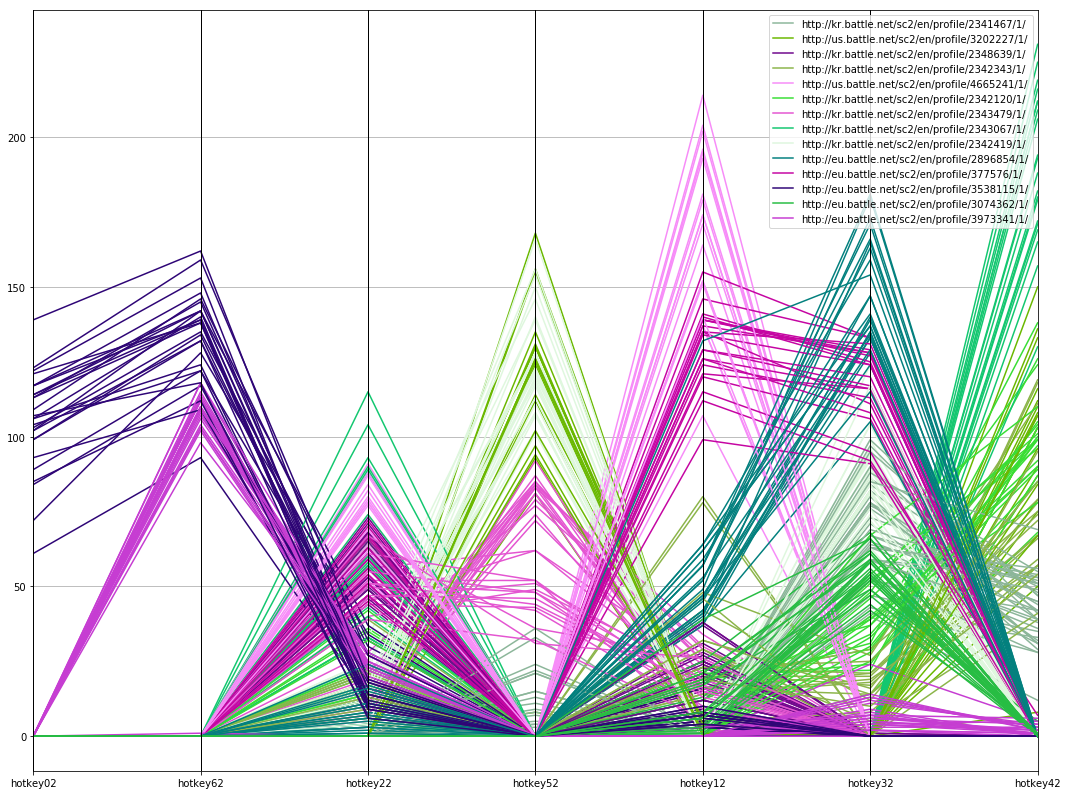

In [14]:
#hotkey02
plt.figure(figsize = (18,14))
parallel_coordinates(df[['user','hotkey02','hotkey62','hotkey22','hotkey52','hotkey12','hotkey32','hotkey42']],'user')

* "Player blue" uses hotkey02 a lot.
* "Player purle" uses hotkey42 a lot.
* "Player brown" uses hotkey32 a lot.
* ...

* Some players are easier to identify than others because they have some obvious/special behavioural traits.

### Split the data into features and labels , training and testing vectors

In [15]:
X = df.loc[:, df.columns != 'user'] # feature vector
# Encode categorical features 
le = preprocessing.LabelEncoder()
#encode race
le.fit(['Terran','Protoss','Zerg'])
X['race']= le.transform(df['race'])
#encode status
le.fit(['Loss','Win'])
X['status']= le.transform(df['status'])
Y = df['user'] # labels 
#split into training and testing
X_train , X_test, Y_train , Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

c:\users\mmegzari8\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\mmegzari8\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Now our features data looks like this :

In [16]:
X_train.head()

,race,status,s,hotkey40,hotkey30,hotkey32,hotkey42,hotkey20,hotkey10,hotkey12,...,hotkey41,hotkey51,hotkey61,hotkey21,hotkey71,hotkey81,hotkey91,hotkey11,hotkey31,APM
15,2,1,42.0,1.0,0.0,0.0,75.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146.312500
6,2,1,67.0,1.0,0.0,0.0,50.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.822306
244,0,0,56.0,0.0,0.0,0.0,0.0,1.0,3.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.716396
222,2,0,140.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.376266
93,0,1,157.0,1.0,0.0,0.0,180.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.700820


> **Decision tree**

In [17]:
#Initialize models
dt = tree.DecisionTreeClassifier(min_samples_leaf=5, criterion = 'entropy',random_state=42)
dt_gini = tree.DecisionTreeClassifier(min_samples_leaf=5, criterion = 'gini',random_state=42)
#training
dt.fit(X_train,Y_train)
dt_gini.fit(X_train,Y_train)
# #testing models
Y_pred = dt.predict(X_test)
Y_pred_gini = dt_gini.predict(X_test) 
#Evaluation
#Cross validation 
print(f'Accuracy of DT with entropy criterion : {np.array(cross_val_score(dt, X, Y,cv=10)).mean()*100}%' )
print(f'Accuracy of DT with gini criterion : {np.array(cross_val_score(dt_gini, X, Y,cv=10)).mean()*100}%' )

Accuracy of DT with entropy criterion : 98.77785204991089%
Accuracy of DT with gini criterion : 97.63469853543383%


#### Purity measurements for DT
With :$p_i$ as the fracion of class i in leaf,N1 the nb of samples in set 1, N2 nb of samples in set 2 and N=N1+N2 :
*  ***gini*** $= 1-\sum p_i^2$
*  ***entropy*** $= -\sum p_i . log_2(p_i)$
***
To compute the impurity of the 2 sets :
* ***purity*** = $\frac {N1}{N}purity1 +\frac {N2}{N}purity2 $

* Here we used cross validation to evaluate our models.More specifically a 10 fold cross validation.Mean of the 10 scores gives the final score of the model.
* Model 1 with entropy purity criterion seems to perform a little bit better than the one with gini criterion.

In [18]:
#classification report
print('With entropy criterion : ')
print(classification_report(Y_test,Y_pred))
print('With gini criterion : ')
print(classification_report(Y_test,Y_pred_gini))

With entropy criterion : 
                                                precision    recall  f1-score   support

http://eu.battle.net/sc2/en/profile/2896854/1/       0.88      1.00      0.93         7
http://eu.battle.net/sc2/en/profile/3074362/1/       0.86      1.00      0.92         6
http://eu.battle.net/sc2/en/profile/3538115/1/       1.00      0.91      0.95        11
 http://eu.battle.net/sc2/en/profile/377576/1/       1.00      1.00      1.00         7
http://eu.battle.net/sc2/en/profile/3973341/1/       1.00      1.00      1.00         8
http://kr.battle.net/sc2/en/profile/2341467/1/       1.00      0.92      0.96        12
http://kr.battle.net/sc2/en/profile/2342120/1/       0.88      1.00      0.93         7
http://kr.battle.net/sc2/en/profile/2342343/1/       1.00      1.00      1.00        10
http://kr.battle.net/sc2/en/profile/2342419/1/       1.00      1.00      1.00        10
http://kr.battle.net/sc2/en/profile/2343067/1/       1.00      1.00      1.00         6
http:

* **Recall** = tp / (tp + fn)
* **Precision** = tp / (tp + fp)

* Precision and recall both look good at 98% and 97% respectively.

In [19]:
#confusion matrix
print(confusion_matrix(Y_test,Y_pred,labels=Y.unique()))

[[11  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  8  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  8]]


In [20]:
#labels in order for the confusion matrix
print(Y.unique())

['http://kr.battle.net/sc2/en/profile/2341467/1/'
 'http://us.battle.net/sc2/en/profile/3202227/1/'
 'http://kr.battle.net/sc2/en/profile/2348639/1/'
 'http://kr.battle.net/sc2/en/profile/2342343/1/'
 'http://us.battle.net/sc2/en/profile/4665241/1/'
 'http://kr.battle.net/sc2/en/profile/2342120/1/'
 'http://kr.battle.net/sc2/en/profile/2343479/1/'
 'http://kr.battle.net/sc2/en/profile/2343067/1/'
 'http://kr.battle.net/sc2/en/profile/2342419/1/'
 'http://eu.battle.net/sc2/en/profile/2896854/1/'
 'http://eu.battle.net/sc2/en/profile/377576/1/'
 'http://eu.battle.net/sc2/en/profile/3538115/1/'
 'http://eu.battle.net/sc2/en/profile/3074362/1/'
 'http://eu.battle.net/sc2/en/profile/3973341/1/']


> **Multi layer perceptron **

In [21]:
# Normalize data for neural network and disgard categorical features(race and status)
X_norm = np.array(normalize(X.iloc[:,2:]))
#X_norm = np.concatenate((np.array(X[['race','status']]),np.array(normalize(X.iloc[:,2:]))),axis=1)
X_train_norm , X_test_norm, Y_train , Y_test = train_test_split(
    X_norm, Y, test_size=0.33, random_state=42)
pd.DataFrame(X_norm).head()#normalized array

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.375232,0.098138,0.005773,0.496460,0.294413,0.0,0.0,0.0,0.086592,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.713153
1,0.417319,0.070623,0.006420,0.539304,0.308174,0.0,0.0,0.0,0.115565,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649212
2,0.448155,0.076827,0.019207,0.499373,0.185664,0.0,0.0,0.0,0.102435,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.706080
3,0.398907,0.138750,0.008672,0.346876,0.104063,0.0,0.0,0.0,0.182110,0.008672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809490
4,0.420005,0.037500,0.022500,0.532506,0.240003,0.0,0.0,0.0,0.097501,0.015000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.682812


Let's try different hidden layer sizes and see how it effects model performance

In [22]:
pd.DataFrame(X_norm).head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.375232,0.098138,0.005773,0.496460,0.294413,0.0,0.0,0.0,0.086592,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.713153
1,0.417319,0.070623,0.006420,0.539304,0.308174,0.0,0.0,0.0,0.115565,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649212
2,0.448155,0.076827,0.019207,0.499373,0.185664,0.0,0.0,0.0,0.102435,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.706080
3,0.398907,0.138750,0.008672,0.346876,0.104063,0.0,0.0,0.0,0.182110,0.008672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809490
4,0.420005,0.037500,0.022500,0.532506,0.240003,0.0,0.0,0.0,0.097501,0.015000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.682812


In [23]:
# perf = []#for storing performance of mlp's
# for i in range(10,40):
#     #build model with 1 hidden layer and i neurons in that layer
#     mlp = MLPClassifier(hidden_layer_sizes=(i),max_iter=2000,random_state=42,solver='adam',verbose=False,batch_size=100,tol=0.0)
#     #cross validation
#     cv_score = np.array(cross_val_score(mlp,X_norm,Y,cv=10)).mean()#compute accuracy of all the folds ans take the mean
#     print(f'CV score with {i} neurons : {cv_score}')
#     perf.append(cv_score)#save accuracy to plot it (in the next cell)

In [24]:
# # How does hidden layer size affect model performance
# plt.figure()
# plt.title('Accuracy as a function of hidden layer size')
# plt.xlabel('size of hidden layer')
# plt.ylabel('Cross validation Accuracy')
# plt.plot(range(10,40),perf)

In [25]:
X_test.shape

(114, 36)

In [26]:
#build model with 1 hidden layer and 18 neurons in that layer
mlp = MLPClassifier(hidden_layer_sizes=(27),max_iter=2000,random_state=42,solver='adam',verbose=False,batch_size=100,tol=0.0)
print(f'cv accuracy : {cross_val_score(mlp,X_norm,Y,cv=10).mean()*100}%')
#train it
mlp.fit(X_train_norm,Y_train)
#test it
Y_pred = mlp.predict(X_test_norm)
#accuracy
print(f'Accuracy of neural network with train test scoring : {accuracy_score(Y_test,Y_pred)*100}%')

cv accuracy : 98.27596413258178%
Accuracy of neural network with train test scoring : 97.36842105263158%


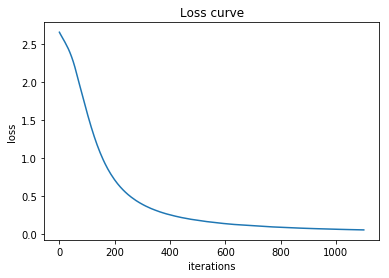

In [27]:
#plot the loss curve for the mlp: loss as a function of the nb of iterations
plt.figure()
plt.xlabel("iterations")
plt.ylabel('loss')
plt.title('Loss curve')
plt.plot(mlp.loss_curve_)

In [28]:
#classification report
print(classification_report(Y_test,Y_pred))

                                                precision    recall  f1-score   support

http://eu.battle.net/sc2/en/profile/2896854/1/       0.88      1.00      0.93         7
http://eu.battle.net/sc2/en/profile/3074362/1/       1.00      0.83      0.91         6
http://eu.battle.net/sc2/en/profile/3538115/1/       1.00      0.91      0.95        11
 http://eu.battle.net/sc2/en/profile/377576/1/       1.00      1.00      1.00         7
http://eu.battle.net/sc2/en/profile/3973341/1/       0.80      1.00      0.89         8
http://kr.battle.net/sc2/en/profile/2341467/1/       1.00      1.00      1.00        12
http://kr.battle.net/sc2/en/profile/2342120/1/       1.00      1.00      1.00         7
http://kr.battle.net/sc2/en/profile/2342343/1/       1.00      1.00      1.00        10
http://kr.battle.net/sc2/en/profile/2342419/1/       1.00      1.00      1.00        10
http://kr.battle.net/sc2/en/profile/2343067/1/       1.00      1.00      1.00         6
http://kr.battle.net/sc2/en/pro

In [29]:
#confusion matrix
print(confusion_matrix(Y_test,Y_pred))

[[ 7  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  7]]


In [30]:
#confusion matrix
mat=confusion_matrix(Y_test,Y_pred)
pd.DataFrame(normalize(mat,axis=1))#?????????????????????? does it work ???????????????

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.196116,0.980581,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.995037,0.0,0.099504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
6,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0
8,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
9,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0


In [31]:
#compute cosine similarity for all player pairs
sim=cosine_similarity(mat)
np.fill_diagonal(sim,0.0)
pd.DataFrame(sim)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.196116,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.196116,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.0,0.099504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012342,0.0
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.099504,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124035,0.0
5,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
6,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
8,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [32]:
print(np.transpose(np.nonzero(sim)))

[[ 0  1]
 [ 1  0]
 [ 2  4]
 [ 2 12]
 [ 4  2]
 [ 4 12]
 [12  2]
 [12  4]]


In [33]:
print(np.array(sim[np.nonzero(sim)]))

[0.19611614 0.19611614 0.09950372 0.01234192 0.09950372 0.12403473
 0.01234192 0.12403473]


In [34]:
aliases = {'p1':np.transpose(np.nonzero(sim))[:,0],'p2':np.transpose(np.nonzero(sim))[:,1],
           'cos similiraty':np.array(sim[np.nonzero(sim)])}
aliases = pd.DataFrame(data=aliases)[['p1','p2','cos similiraty']]
aliases.sort_values('cos similiraty',ascending=False)

,p1,p2,cos similiraty
0,0,1,0.196116
1,1,0,0.196116
5,4,12,0.124035
7,12,4,0.124035
2,2,4,0.099504
4,4,2,0.099504
3,2,12,0.012342
6,12,2,0.012342
